Utils

In [24]:
import imageio
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
to_pil_image = transforms.ToPILImage()
def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('/datax/scratch/kai_mul/BreakthroughAutoencoder/TestOutputs/generated_images.gif', imgs)
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"/datax/scratch/kai_mul/BreakthroughAutoencoder/TestOutputs/output{epoch}.jpg")
def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/datax/scratch/kai_mul/BreakthroughAutoencoder/TestOutputsloss.jpg')
    plt.show()

Engine

In [25]:
from tqdm import tqdm
import torch 
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter 
    return train_loss

def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction
    val_loss = running_loss / counter
    return val_loss, recon_images


model

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 16 # latent dimension for sampling


# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

train

In [27]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import matplotlib
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
matplotlib.style.use('ggplot')

In [31]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
epochs = 20
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

In [32]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
# training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='../input', train=True, download=True, transform=transform
)
trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
# validation set and validation data loader
testset = torchvision.datasets.MNIST(
    root='../input', train=False, download=True, transform=transform
)
testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=False
)

In [33]:
from tqdm.notebook import tqdm
train_loss = []
valid_loss = []
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 14929.4543
Val Loss: 11555.7596
Epoch 2 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 11187.5529
Val Loss: 10806.3336
Epoch 3 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 10686.7737
Val Loss: 10413.9393
Epoch 4 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 10417.4462
Val Loss: 10297.6089
Epoch 5 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 10268.4791
Val Loss: 10167.0105
Epoch 6 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 10191.5578
Val Loss: 10055.0379
Epoch 7 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 10094.6348
Val Loss: 9976.8507
Epoch 8 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 9978.7433
Val Loss: 9840.1247
Epoch 9 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 9910.5216
Val Loss: 9906.0219
Epoch 10 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 9840.9944
Val Loss: 9737.5620
Epoch 11 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 9775.1914
Val Loss: 9679.4387
Epoch 12 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 9709.9573
Val Loss: 9601.6163
Epoch 13 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 9680.3115
Val Loss: 9630.5375
Epoch 14 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 9655.5125
Val Loss: 9602.8376
Epoch 15 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 9632.8996
Val Loss: 9589.4552
Epoch 16 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 9615.6846
Val Loss: 9594.7389
Epoch 17 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 9598.8925
Val Loss: 9558.0371
Epoch 18 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 9591.4861
Val Loss: 9586.0804
Epoch 19 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 9569.7518
Val Loss: 9533.5497
Epoch 20 of 20


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Train Loss: 9565.0107
Val Loss: 9532.4560


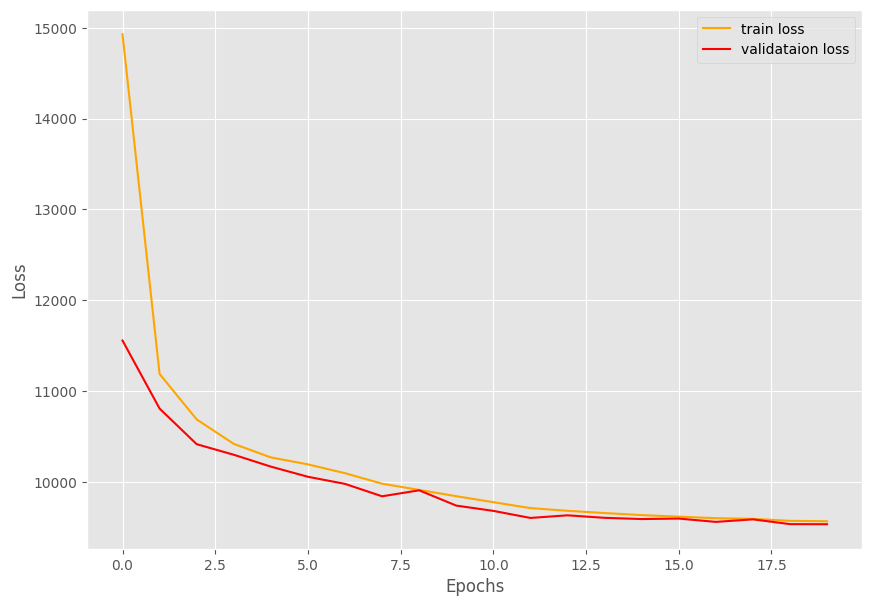

TRAINING COMPLETE


In [34]:
# save the reconstructions as a .gif file
image_to_vid(grid_images)
# save the loss plots to disk
save_loss_plot(train_loss, valid_loss)
print('TRAINING COMPLETE')

In [ ]:
data_shape = np.load('Data/HIP13402-2/shape.npy')
data_shape = tuple(int(dim) for dim in data_shape)
file_name = 'Data/HIP13402-2/seperated_raw_data.npy'
data = np.memmap(file_name, dtype='float32', mode='r+', shape=data_shape)
# data2 = inject_signals(data[10000:12000], signal_split, true_false_split, np.array([1000, 0, 10000.0]), num_workers=20)
print(f"Data shape: {data.shape}")
for i in range(0,100,10):
    # subplot now
    fig, axs = plt.subplots(6, 1)
    for j in range(6):
        axs[j].imshow(data[i, j, :, :], aspect='auto')
    # plt.savefig(f"2test{i}.png")
    # plt.close()